# Transformer Introduction

This notebook contains my live notes about the Transformer architecture: https://arxiv.org/pdf/1706.03762

**The Setup**:

- $Attention(Q,K, V) = Softmax(QK^{T} / \sqrt{d_{k}})V$ - Context-aware sequence representation
- $d_{k} = d_{q}$ - query and key space dimension

Here, pay attention that $(QK^{T})_{i,j} = \Sigma_{l=1}^{d_{k}}q^{i}_{l}k^{j}_{l}$ - The dot product between the i'th query vector and k'th key vector.

Now, for a matrix $M \in R^{d_{k} \times d_{k}}$, $Softmax(M)_{i,j} = \frac{e^{M_{i,j}}}{\Sigma_{k=1}^{d_{k}}e^{M_{i,k}}}$ - essentially a normalization of a row into a probability distribution.

**Intuition**: So the higher the dot product between each query and key vector relative to other elements in the row - the higher the likelihood of match between the specific query and key.

**Attention element:** 

$Attention(Q,K,V)_{i,j} = \Sigma_{l=1}^{d_{k}}Attention(Q,K,V)_{i,l}V_{l,j} = \Sigma_{l=1}^{d_{k}}Softmax(QK^{t}/\sqrt{d_{k}})_{i,l}V_{l,j} = \Sigma_{l=1}^{d_{k}} \frac{e^{(QK^{T}/\sqrt{d_{k}})_{i,l}}}{\Sigma_{m=1}^{d_{k}} e^{(QK^{T}/\sqrt{d_{k}})_{i,m}}}V_{l,j} = \frac{1}{\Sigma_{m=1}^{d_{k}} e^{(QK^{T}/\sqrt{d_{k}})_{i,m}}} \Sigma_{l=1}^{d_{k}} e^{(QK^{T}/\sqrt{d_{k}})_{i,l}}V_{l,j}$

So, the final result is: $Attention(Q,K,V)_{i,j} = \frac{1}{\Sigma_{m=1}^{d_{k}} e^{(QK^{T}/\sqrt{d_{k}})_{i,m}}} \Sigma_{l=1}^{d_{k}} e^{(QK^{T}/\sqrt{d_{k}})_{i,l}}V_{l,j}$ - Each entry of the attention matrix is the weighted average of the $l$'th value column, where the weights of the average are the scores of matching the query $i$ to the key $l$.

**Dimensions**

Here $n$ - number of elements in the sequence

- Queries $Q \in \mathbb{R}^{n \times d_{q}}$
- Keys $K \in \mathbb{R}^{n \times d_{k}}$
- $QK^{T} \in \mathbb{R}^{n \times n}$ - Softmax does not change the dimensions of the matrix
- The above means that the Value matrix is $V \in \mathbb{R}^{n \times d_{v}}$
- $Attention(Q,V,K) \in \mathbb{R}^{n \times d_{v}}$

Here, keep in mind that $d_{model}$ is the dimension of the latent space of your original data. In the case of words, if the original word is $x$, we need to obtain a latent representation of the word $f(x) = z \in \mathbb{R}^{d_{model}}$, where $f$ is some sort of encoder that takes us from the data space to the latent space (often a linear mapping).

**How do we get Q,V,K?**

Here, we will assume that $\mathcal{Z} \in \mathbb{R}^{d_{model} \times n}$ is a matrix holding the embeddings with positional encodings added (look below). 

The way we go from embeddings to Q,K,V is by linear projections via matrices:

- $W^{Q} \in \mathbb{R}^{d_{model} \times d_{q}}$
- $W^{K} \in \mathbb{R}^{d_{model} \times d_{k}}$
- $W^{V} \in \mathbb{R}^{d_{model} \times d_{v}}$

Then, respectively we go to Q,K,V as:

- $Q = \mathcal{Z}^{T}W^{Q}$
- $K = \mathcal{Z}^{T}W^{K}$
- $V = \mathcal{Z}^{T}W^{V}$

In [261]:
%load_ext autoreload
%autoreload 2

import jax.numpy as jnp
import jax

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Positional Encodings

https://kazemnejad.com/blog/transformer_architecture_positional_encoding/

Since the transformer encoder takes the whole sequence all at once we loose information about the position of the embedding in the sequence.

The two encodings are represented in terms of frequency encodings:

- $PE_(pos, 2i) = \sin(pos / 10000^{2i / d_{model}})$ - represents the imaginary part of the frequency
- $PE_(pos, 2i + 1) = \cos(pos / 10000^{2i / d_{model}})$ - represents the real part of the frequency

Here $pos$ is the position of the element, and $i$ is the dimension, so essentially the positional encoding matrix should have the form $\mathbb{R}^{d_{model} \times n}$, and should essentially be added to the encoding.

**Idea**: The idea here is that for the same position and dimension the values of the positional encoding might be close, but at higher dimensions and hence higher frequencies they will be further apart and hence identifiable - look at the graph below 

The following cell demonstrates the concept of the positional embedding

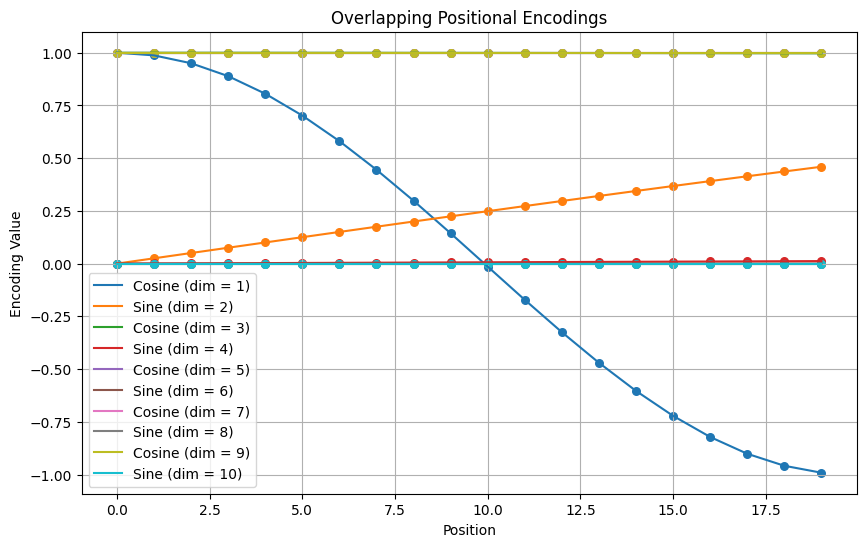

In [262]:
def sin_freq_encoding(pos, i, d_model=256):
    c = 10000 ** (2 * i / d_model)
    return jnp.sin(pos / c)

def cos_freq_encoding(pos, i, d_model=256):
    c = 10000 ** (2 * i / d_model)
    return jnp.cos(pos / c)

x = jnp.array(list(range(0, 20)))

plt.figure(figsize=(10, 6))
for i in range(1, 11):
    if i % 2 == 1:
        encoding = cos_freq_encoding(x, i, d_model=10)
        label = f'Cosine (dim = {i})'
    else:
        encoding = sin_freq_encoding(x, i, d_model=10)
        label = f'Sine (dim = {i})'
    
    plt.plot(x, encoding, label=label)
    plt.scatter(x, encoding, s=30)  # scatter points to highlight each value

plt.title('Overlapping Positional Encodings')
plt.xlabel('Position')
plt.ylabel('Encoding Value')
plt.legend()
plt.grid(True)
plt.show()

### Transformer encoder overview

So on a higher level, the flow is as following:

1. Take your sequence in the data space and map it to the latent space via some encoder $z = f(x)$
2. Add positional encodings to your sequence $z_{p} = z + p$
3. Obtain q,k,v via $q = z^{T}Q^{W}$, $k = z^{T}Q^{K}$, $v = z^{T}Q^{V}$
4. Compute $Attention(Q,K,V)$ - context aware representation

See the full attention implementation layer below

In [263]:
import equinox as eqx
from jax.nn import softmax

d_m = 19
d_q = d_k = 10
d_v = 15
n = 100

key = jax.random.PRNGKey(123123)
random_array = jax.random.uniform(key, shape=(10, 100)) # d_model x n


class PositionalEncoding(eqx.Module):
    def __init__(self, d_model, C=10000):
        self.d_model = d_model
        self.C = C

    def __call__(self, x):
        even_dim_elements = x[::2, ::]
        odd_dim_elements = x[1::2, ::]
        dimensions = jnp.arange(self.d_model)

        # Have an array for all positions
        positions = jnp.arange(x.shape[1])

        even_denominators = self.C ** (2 * dimensions[::2] / self.d_model)
        odd_denominators = self.C ** (2 * dimensions[1::2] / self.d_model)

        sin_inputs = jnp.expand_dims(positions, 0) / jnp.expand_dims(even_denominators, 1)
        cos_inputs = jnp.expand_dims(positions, 0) / jnp.expand_dims(odd_denominators, 1)

        cos_pos_enc = jnp.cos(cos_inputs)
        sin_pos_enc = jnp.sin(sin_inputs)

        return x.at[::2, ::].add(sin_pos_enc).at[1::2, ::].add(cos_pos_enc)


class SelfAttention(eqx.Module):
    Q_linear: eqx.nn.Linear
    K_linear: eqx.nn.Linear
    V_linear: eqx.nn.Linear
    
    def __init__(self, d_model, d_key, d_value):
        k = jax.random.PRNGKey(0)

        self.Q_linear = eqx.nn.Linear(in_features=d_model, out_features=d_key, use_bias=False, key=k)
        self.K_linear = eqx.nn.Linear(in_features=d_model, out_features=d_key, use_bias=False, key=k)
        self.V_linear = eqx.nn.Linear(in_features=d_model, out_features=d_value, use_bias=False, key=k)

    # z is expected to come in as (d_model, N)
    def __call__(self, z):        
        Q = self.Q_linear(z).T # Transposing because we want to get the output (N, d_q)
        K_T = self.K_linear(z) # Not transposing, because we will need this version later - expecting (d_k, N)
        V = self.V_linear(z).T # Transposing because we want to get the output (N, d_v)
        
        return softmax(Q @ K_T / K_T.shape[0], axis=1) @ V

rand_k = jax.random.PRNGKey(123123)
rand_inp = jax.random.uniform(rand_k, shape=(d_m, 100))
att = SelfAttention(d_m, d_q, d_v)(rand_inp)

assert att.shape[0] == n, 'Invalid seq_len dimension'
assert att.shape[1] == d_v, 'Invalid value dimension'

In [266]:
# Integrating multi-head attention layer

from typing import List

class MultiHeadAttention(eqx.Module):
    heads: List[SelfAttention]
    projection_matrix: eqx.nn.Linear
    
    def __init__(self, d_model, d_key, d_value, n_heads):
        k = jax.random.PRNGKey(0)
        self.heads = [SelfAttention(d_model, d_key, d_value) for i in range(n_heads)]
        self.projection_matrix = eqx.nn.Linear(in_features=n_heads * d_value, out_features=d_model, key=k, use_bias=False)

    def __call__(self, z):
        head_outputs = jnp.array([head(z) for head in self.heads])
        heads_concattenated = jnp.concatenate(head_outputs, axis=1) # (n x (n_heads * d_v))

        return heads_concattenated @ self.projection_matrix.weight.T


shape = MultiHeadAttention(d_m, d_q, d_v, 3)(rand_inp).shape

assert shape[0] == n, 'Batch dimension is incorrect'
assert shape[1] == d_m, 'Model dimension is incorrect'